In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Challenge: Feedback analysis

First, I created a Naive Bayes Classifier to classify the provided Amazon feedback data as either positive or negative.

## Amazon Feedback

In [3]:
data_path = ('sentiments/amazon_cells_labelled.txt')
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['text', 'Positive']

df.head()

,text,Positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


By using connotative keywords such as 'great', 'love', 'best', 'waste', 'problem', and 'disappointed', I was able to create a model that classified the feedback text as positive or negative with 70.6% accuracy.

In [75]:
from collections import Counter
import re

common_words = ['a', 'about', 'am', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'can', 'did', 'do', 'does', 'for', 'from', 'had', 'has', 'have', 'having', 'i', "i'm", "i've", 'in', 'is', 'it', "it's", 'its', 'me', 'my', 'of', 'on', 'or', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'will', 'with', 'within', 'you', 'your']
domain_specific_words = ['amazon', 'audio', 'batteries', 'battery', 'bluetooth', 'buttons', 'camera', 'car', 'cars', 'charger', 'device', 'ear', 'ears', 'earset', 'headphones', 'headset', 'jabra', 'jawbone', 'motorola', 'nokia', 'phone', 'plug', 'samsung', 'software', 'sound', 'verizon']
all_words = []
for row in df.iterrows():
    sentence = row[1]['text'].lower()
    sentence = re.sub("[^a-zA-Z' ]+", '', sentence)
    words = sentence.split()
    for word in words:
        if len(word) > 0 and word not in common_words and word not in domain_specific_words:
            all_words.append(word)

counts = Counter(all_words)
keywords = [k for k, v in counts.items() if v > 10]

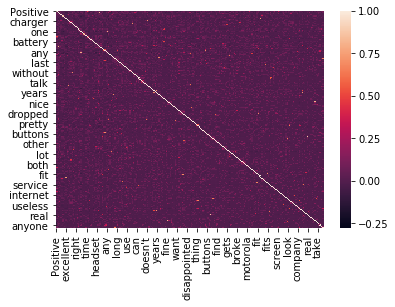

BASELINE: 82.1% accuracy
Testing "so": 0.2% in accuracy
Testing "no": -1.3% in accuracy
Testing "good": -0.8% in accuracy
Testing "case": 0.1% in accuracy
Testing "excellent": -0.1% in accuracy
Testing "great": -5.0% in accuracy
Testing "more": -0.1% in accuracy
Testing "than": -0.1% in accuracy
Testing "problems": 0.0% in accuracy
Testing "get": 0.1% in accuracy
Testing "up": 0.1% in accuracy
Testing "right": 0.1% in accuracy
Testing "volume": 0.2% in accuracy
Testing "if": -0.2% in accuracy
Testing "one": 0.1% in accuracy
Testing "money": -0.1% in accuracy
Testing "waste": 0.0% in accuracy
Testing "time": 0.1% in accuracy
Testing "quality": 0.0% in accuracy
Testing "very": -0.5% in accuracy
Testing "two": 0.2% in accuracy
Testing "design": 0.0% in accuracy
Testing "not": -1.2% in accuracy
Testing "comfortable": -0.2% in accuracy
Testing "all": 0.0% in accuracy
Testing "recommend": -0.4% in accuracy
Testing "any": 0.0% in accuracy


In [ ]:
for key in keywords:
    df[str(key)] = df.text.str.contains(str(key), case=False)

sns.heatmap(df.corr())
plt.show()

data = df[keywords]
target = df['Positive']

bnb = BernoulliNB()
bnb.fit(data, target)

my_predictions = bnb.predict(data)
baseline = ((target == my_predictions).sum()/data.shape[0]) * 100
print('BASELINE: {}% accuracy'.format(baseline))

def train_on_original_data(keywords):
    for key in keywords:
        df[str(key)] = df.text.str.contains(str(key), case=False)

    data = df[keywords]
    target = df['Positive']

    bnb = BernoulliNB()
    bnb.fit(data, target)

    my_predictions = bnb.predict(data)
    
    return ((target == my_predictions).sum()/data.shape[0]) * 100

# print(len(keywords))
def backwards_pass(keywords):
    answer_key = {}
    for keyword in keywords:
        test_keywords = keywords[:]
        test_keywords.remove(keyword)
        percentage = train_on_original_data(test_keywords)
        answer_key[keyword] = percentage
        print('Testing "{}": {}% in accuracy'.format(keyword, round(percentage - baseline, 2)))
    
    min_key = min(answer_key, key=answer_key.get)
    min_val = min([v for k, v in answer_key.items()])
    
    answer_key.pop(min_key, None)
    remaining_keywords = list(answer_key.keys())
#     if min_val < 78:
#         return pare_down(list(remaining_keywords))
#     else:
    return list(remaining_keywords)

new_keywords = backwards_pass(keywords)
train_on_original_data(new_keywords)

However, using this same classifier on other datasets (in this case, for IMDB movie reviews and Yelp restaurant reviews) shows that these types of classifiers do not always translate well from one context to another.

For IMDB reviews, using the same model to predict sentiment resulted in a 59.0% prediction accuracy rate. For Yelp reviews, it dropped to 65.1%. 

This disparity in accuracy is due to the fact that positive and/or negative keywords are not the same from domain to domain (e.g. e-commerce, movie review, restaurant review, etc.).

## IMDB Reviews

In [83]:
def test_model_against_dataset(the_dataframe, keywords, bnb):
    for key in keywords:
        the_dataframe[str(key)] = the_dataframe.text.str.contains(str(key), case=False)
    
    data = the_dataframe[keywords]
    target = the_dataframe['Positive']
    
    sns.heatmap(the_dataframe.corr())
    plt.show()
    
    my_predictions = bnb.predict(data)

    print('{}% accuracy'.format(((target == my_predictions).sum()/data.shape[0]) * 100))

In [84]:
imdb_data_path = ('sentiments/imdb_labelled.txt')
imdb_df = pd.read_csv(imdb_data_path, delimiter= '\t', header=None)
imdb_df.columns = ['text', 'Positive']

imdb_df.head()

,text,Positive
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


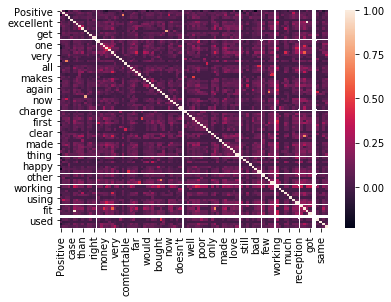

59.893048128342244% accuracy


In [85]:
test_model_against_dataset(imdb_df, keywords, bnb)

## Yelp Reviews

In [86]:
yelp_data_path = ('sentiments/yelp_labelled.txt')
yelp_df = pd.read_csv(yelp_data_path, delimiter= '\t', header=None)
yelp_df.columns = ['text', 'Positive']

yelp_df.head()

,text,Positive
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


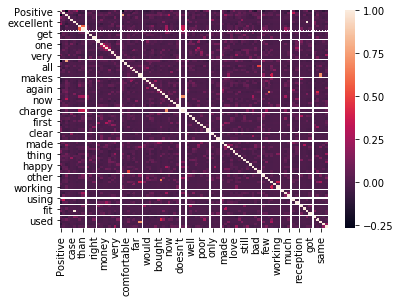

70.6% accuracy


In [87]:
test_model_against_dataset(yelp_df, keywords, bnb)